# Honor cup 
In this problem, you have to restore the image, if it was previously divided into square fragments of **p×p** pixels, which were shuffled randomly. You are given a set of images, each has a size of **512×512** pixels. Divide each image into **m×m** square fragments of **pxp** pixels (m=512/p) and rearrange them to restore the original image. It is guaranteed that all original images are regular photos (perhaps with some minor vertical/horizontal scales).

For each image, you can get from 0 to 100 points. The score for the image is equal to the ratio of correctly defined **"edges"** between the images. Here, by an "edge" we call a horizontal or vertical segment of length p pixels, which separates two adjacent fragments along the side. An "edge" is defined correctly if output contains the edge the answer (the order of the fragments "bottom-top" or "left-right" matters). The total number of such "edges" is **2⋅m⋅(m−1)=k**. Formally, the score for the image will be **100⋅a/k**, where **a** is the number of correct "edges". Points for the images in a test are summarized. If you do not provide an answer to the image, then the score for it is 0.

Problem A contains tests with parameters p=64, m=8, k=112. Problem B contains tests with parameters p=32, m=16, k=480. Problem C contains tests with parameters p=16, m=32, k=1984. Each problem is divided into three subproblems.

Connect with google drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Import necessary packages to simulate the process

In [0]:
# Import necessary packages
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
torch.manual_seed(42)

Using TensorFlow backend.


Load train data in numpy array.
As they colorful image, making grayscale false

torch.Size([600, 512, 512, 3])


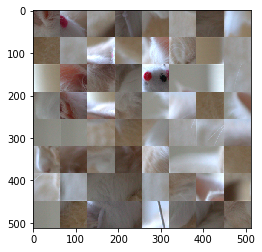

In [0]:
train_image = []
for i in range(1200,1800):
    img = image.load_img('/content/gdrive/My Drive/Colab Notebooks/data_train/64/'+str(i).zfill(4)+'.png', target_size=(512,512,1), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
x = np.array(train_image)
X = torch.from_numpy(x)
print(X.shape)
plt.imshow(X[0])

Read answer file and get the lines in an array

In [0]:
# Open file    
fileHandler = open ("/content/gdrive/My Drive/Colab Notebooks/data_train/data_train_64_answers.txt", "r")
 
# Get list of all lines in file
listOfLines = fileHandler.readlines()
 
# Close file 
fileHandler.close()

Print first 6 lines

In [0]:
for line in listOfLines[:6]:
    print(line.strip()) 

1200.png
32 21 22 16 14 60 29 39 33 31 54 26 10 20 1 41 56 28 12 17 25 58 59 43 45 46 44 18 0 3 62 6 38 48 13 63 27 19 50 51 23 37 40 53 42 24 61 57 52 15 5 34 36 4 35 8 49 9 2 55 7 11 47 30
1201.png
11 2 9 19 29 0 17 10 40 21 57 54 61 56 4 31 24 35 37 52 18 63 34 55 20 22 36 48 13 28 23 44 42 12 26 59 51 16 62 46 1 27 60 33 58 8 30 15 50 43 7 39 5 6 49 47 3 38 45 32 41 14 25 53
1202.png
20 46 42 6 26 5 44 28 60 63 0 29 25 17 34 27 11 10 38 62 59 9 22 2 1 52 12 16 55 45 7 3 41 51 33 43 15 39 53 31 37 56 61 23 21 47 19 50 57 54 48 24 13 49 30 18 4 35 32 36 14 8 58 40


Take the answer line and split them by space.
Then the data store in an array.

In [0]:
i=0
train_answer=[]
for line in listOfLines:
    i=i+1
    if i%2==1:
        continue
    string_line=line.strip().split() 
    answer_line=[]
    for num in string_line:
        answer_line.append(int(num))
    train_answer.append(answer_line)
y=np.array(train_answer)
Y=torch.from_numpy(y)
print(Y.shape)

torch.Size([600, 64])


Restore permuted image.

In [0]:
def restore_image(p_images,permutation):
    images=p_images.clone()
    for i in range(8):
        for j in range(8):
            sr=i*64
            sc=j*64
            #print('{:d} {:d}'.format(sr,sc))
            tr=permutation[i*8+j]//8
            tc=permutation[i*8+j]%8
            tc=tc*64
            tr=tr*64
            #print('{:d} {:d}'.format(tr,tc))
            #sr, sc = perm_inds[j]
            #tr, tc = perm_inds[perms[i, j]]
            images[ sr:sr+64, sc:sc+64,:] = p_images[ tr:tr+64, tc:tc+64,:]
    return images

Testing restore function.

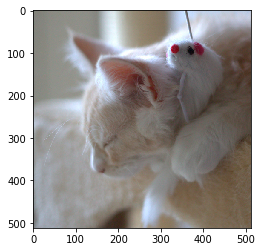

In [0]:
r_image=restore_image(X[0],Y[0])
plt.imshow(r_image)

Make the train loader.

In [0]:
def perm2vecmat2x2(perms):
    """
    Converts permutation vectors to vectorized assignment matrices.
    """
    n = perms.size()[0]
    mat = torch.zeros(n, 64, 64)
    # m[i][j] : i is assigned to j
    for i in range(n):
        for k in range(64):
            mat[i, k, perms[i, k]] = 1.
    return mat.view(n, -1)
def vecmat2perm2x2(x):
    """
    Converts vectorized assignment matrices back to permutation vectors.
    Note: this function is compatible with GPU tensors.
    """
    n = x.size()[0]
    x = x.view(n, 64, 64)
    _, ind = x.max(2)
    return ind
    

In [0]:
train_set = torch.utils.data.TensorDataset(X, Y)
sample_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
dataiter = iter(sample_loader)
images, labels = next(dataiter)
z=perm2vecmat2x2(labels)
vecmat2perm2x2(z)
#r_image=restore_image(images[0],labels[0])
#plt.imshow(r_image)

tensor([[34,  7, 40, 15, 32, 23, 43, 52, 35, 31, 51, 57, 62, 17, 21,  0, 20, 47,
         38, 29,  5, 22, 12, 39, 44,  1, 33, 45, 59, 54, 14, 28, 37, 27, 30, 18,
         48, 63, 16, 24, 46, 10, 41, 36, 55,  4, 60,  9, 42, 53, 13, 19,  6, 50,
         26, 61,  2,  3, 56, 49, 25,  8, 58, 11],
        [43, 23,  6, 24, 50,  8, 14, 10, 49, 31, 27, 42, 58, 30, 33, 11, 56, 54,
          0,  3, 16, 13, 28, 37,  9, 38, 53, 47, 41, 45, 39,  1, 61,  5,  4, 59,
         44, 52, 63, 51, 12, 20, 62, 19, 55, 35, 17, 60, 18, 40, 46, 21,  7,  2,
         29, 48, 57, 22, 25, 26, 34, 36, 15, 32],
        [19, 37, 29, 14, 40, 54,  1, 57, 21, 23, 33, 49, 38, 44, 32,  8, 22,  0,
          3,  6, 11, 10, 63, 58, 47, 16, 15, 39, 43, 53, 62, 60, 45, 31,  7, 35,
         34, 50, 48, 56, 41, 18, 46, 42, 13, 17, 24,  9, 61, 27, 51, 20, 55, 28,
          2, 25, 59, 26,  4, 52, 36,  5, 12, 30],
        [60, 45, 36, 12, 26, 63,  2, 48, 19, 40,  8, 37, 38, 27, 53, 49, 25, 30,
         23,  1,  7,  9, 43, 51, 34, 39,

Prepare training set and validation set

In [0]:
# Prepare training, validation, and test samples.

validation_ratio = 0.1
total = len(train_set)
ind = list(range(total))
n_train = int(np.floor((1. - validation_ratio) * total))
train_ind, validation_ind = ind[:n_train], ind[n_train:]
train_subsampler = torch.utils.data.sampler.SubsetRandomSampler(train_ind)
validation_subsampler = torch.utils.data.sampler.SubsetRandomSampler(validation_ind)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=8,
                                           sampler=train_subsampler, num_workers=0)
validation_loader = torch.utils.data.DataLoader(train_set, batch_size=8,
                                                sampler=validation_subsampler, num_workers=0)

print('Number of training batches: {}'.format(len(train_loader)))
print('Number of validation batches: {}'.format(len(validation_loader)))


Number of training batches: 68
Number of validation batches: 8


Make simple model

In [0]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def sinkhorn(A, n_iter=4):
    """
    Sinkhorn iterations.
    """
    for i in range(n_iter):
        A /= A.sum(dim=1, keepdim=True)
        A /= A.sum(dim=2, keepdim=True)
    return A

class SimpleConvNet(nn.Module):
    """
    A simple convolutional neural network shared among all pieces.
    """
    def __init__(self):
        super().__init__()
         # 3 x 64 x 64 input
        self.conv1 = nn.Conv2d(3, 8, 3)
        # 8 x 62 x 62
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.conv2_bn = nn.BatchNorm2d(8)
        # 8 x 60 x 60
        self.pool1 = nn.MaxPool2d(2, 2)
        # 8 x 30 x 30
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.conv3_bn = nn.BatchNorm2d(16)
        # 16 x 28 x 28
        self.fc1 = nn.Linear(16*28*28, 512)
        self.fc1_bn = nn.BatchNorm1d(512)
        # 128-d features
        self.fc2 = nn.Linear(512, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
    
    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        #print(x.shape)
        x = self.pool1(x)
        #print(x.shape)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        #print(x.shape)
        x = x.view(-1, 16*28*28)
        #print(x.shape)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        #print(x.shape)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        #print(x.shape)
        return x

class JigsawNet(nn.Module):
    """
    A neural network that solves 2x2 jigsaw puzzles.
    """
    def __init__(self, sinkhorn_iter=0):
        super().__init__()
        self.conv_net = SimpleConvNet()
        self.fc1 = nn.Linear(512*64, 8192)
        self.fc1_bn = nn.BatchNorm1d(8192)
        # 4 x 4 assigment matrix
        self.fc2 = nn.Linear(8192, 4096)
        self.sinkhorn_iter = sinkhorn_iter
    
    def forward(self, x):
        # Split the input into four pieces and pass them into the
        # same convolutional neural network.
        piece=[]
        for i in range (8):
            for j in range(8):
                one=self.conv_net(x[:,:, i*64:i*64+64, i*64:i*64+64])
                piece.append(one)
        # Cat
        x = torch.cat(piece, dim=1)
        #print(x.shape)
        # Dense layer
        x = F.dropout(x, p=0.1, training=self.training)
        #print(x.shape)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        if self.sinkhorn_iter > 0:
            x = x.view(-1, 64, 64)
            x = sinkhorn(x, self.sinkhorn_iter)
            x = x.view(-1, 4096)
        return x

Test helper

In [0]:
# Test helper
def compute_acc(p_pred, p_true, average=True):
    """
    We require that the location of all four pieces are correctly predicted.
    Note: this function is compatible with GPU tensors.
    """
    # Remember to cast to float.
    n = torch.sum((torch.sum(p_pred == p_true, 1) == 64).float())
    if average:
        return n / p_pred.size()[0]
    else:
        return n


Tester

In [0]:

# Training process
def train_model(model, criterion, optimizer, train_loader, validation_loader,
                n_epochs=40, save_file_name=None):
    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []
    for epoch in range(n_epochs):
        with tqdm(total=len(train_loader), desc="Epoch {}".format(epoch + 1), unit='b', leave=False) as pbar:
            # Training phase
            model.train()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(train_loader, 0):
                inputs, perms = data
                x_in=inputs
                x_in=x_in.permute(0,3,1,2)
                
                #print(x_in.shape)
                y_in = perm2vecmat2x2(perms)
                
                n_samples += inputs.size()[0]
                if is_cuda_available:
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                optimizer.zero_grad()
                outputs = modelb(x_in)
                n_correct_pred += compute_acc(vecmat2perm2x2(outputs), perms, False)
                loss = criterion(outputs, y_in)
                print(loss)
                loss.backward()
                optimizer.step()
                running_loss += loss * x_in.size()[0]
                pbar.update(1)
            loss_history.append(running_loss / n_samples)
            acc_history.append(n_correct_pred / n_samples)
            
            # Validation phase
            model.eval()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(validation_loader, 0):
                inputs, perms = data
                x_in=inputs
                x_in=x_in.permute(0,3,1,2)
                j
                #print(x_in.shape)
                y_in = perm2vecmat2x2(perms)
                n_samples += inputs.size()[0]
                if is_cuda_available:
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                outputs = model(x_in)
                n_correct_pred += compute_acc(vecmat2perm2x2(outputs), perms, False)
                loss = criterion(outputs, y_in)
                running_loss += loss * x_in.size()[0]
            val_loss_history.append(running_loss / n_samples)
            val_acc_history.append(n_correct_pred / n_samples)
            
            # Update the progress bar.
            print("Epoch {0:03d}: loss={1:.4f}, val_loss={2:.4f}, acc={3:.2%}, val_acc={4:.2%}".format(
                epoch + 1, loss_history[-1], val_loss_history[-1], acc_history[-1], val_acc_history[-1]))
    print('Training completed')
    history = {
        'loss': loss_history,
        'val_loss': val_loss_history,
        'acc': acc_history,
        'val_acc': val_acc_history
    }
    # Save the model when requested.
    if save_file_name is not None:
        torch.save({
            'history': history,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, save_file_name)
    return history


Test process

In [0]:

# Test process
# Compute the accuracy
def test_model(model, test_loader):
    running_acc = 0.
    n = 0
    model.eval()
    for i, data in enumerate(test_loader, 0):
        inputs, perms = data
        x_in=inputs
        x_in=x_in.permute(0,3,1,2)
                
        #print(x_in.shape)
        y_in = perm2vecmat2x2(perms)
        if is_cuda_available:
            x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
        else:
            x_in, y_in = Variable(x_in), Variable(y_in)
        pred = model(x_in)
        perms_pred = vecmat2perm2x2(pred.cpu().data)
        running_acc += compute_acc(perms_pred, perms, False)
        n += x_in.size()[0]
    acc = running_acc / n
    return acc


Main process

In [0]:
n_epochs = 50
sinkhorn_iter = 5

# Create the neural network.
model = JigsawNet(sinkhorn_iter=sinkhorn_iter)
is_cuda_available = torch.cuda.is_available();
if is_cuda_available:
    model.cuda()

n_params = 0
for p in model.parameters():
    n_params += np.prod(p.size())
print('# of parameters: {}'.format(n_params))

# We use binary cross-entropy loss here.
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Train

history = train_model(model, criterion, optimizer, train_loader, validation_loader,
                      n_epochs=n_epochs)


Epoch 1:   0%|          | 0/68 [00:00<?, ?b/s]

# of parameters: 308708328
tensor(0.7369, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:   1%|▏         | 1/68 [00:08<10:00,  8.96s/b]

tensor(0.7052, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:   3%|▎         | 2/68 [00:14<08:52,  8.07s/b]

tensor(0.7052, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:   4%|▍         | 3/68 [00:21<08:10,  7.55s/b]

tensor(0.7091, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:   6%|▌         | 4/68 [00:26<07:27,  6.99s/b]

tensor(0.7087, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:   7%|▋         | 5/68 [00:32<06:55,  6.60s/b]

tensor(0.7036, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:   9%|▉         | 6/68 [00:38<06:32,  6.33s/b]

tensor(0.7065, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  10%|█         | 7/68 [00:43<06:12,  6.11s/b]

tensor(0.7152, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  12%|█▏        | 8/68 [00:49<05:53,  5.89s/b]

tensor(0.7030, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  13%|█▎        | 9/68 [00:54<05:37,  5.73s/b]

tensor(0.7051, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  15%|█▍        | 10/68 [01:00<05:25,  5.61s/b]

tensor(0.7044, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  16%|█▌        | 11/68 [01:05<05:15,  5.53s/b]

tensor(0.7029, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  18%|█▊        | 12/68 [01:10<05:06,  5.47s/b]

tensor(0.7199, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  19%|█▉        | 13/68 [01:16<05:00,  5.46s/b]

tensor(0.7027, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  21%|██        | 14/68 [01:21<04:56,  5.49s/b]

tensor(0.7174, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  22%|██▏       | 15/68 [01:27<04:50,  5.48s/b]

tensor(0.7103, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  24%|██▎       | 16/68 [01:32<04:42,  5.44s/b]

tensor(0.7106, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  25%|██▌       | 17/68 [01:37<04:35,  5.41s/b]

tensor(0.7067, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  26%|██▋       | 18/68 [01:43<04:29,  5.39s/b]

tensor(0.7074, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  28%|██▊       | 19/68 [01:48<04:23,  5.37s/b]

tensor(0.7222, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  29%|██▉       | 20/68 [01:53<04:17,  5.37s/b]

tensor(0.7027, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  31%|███       | 21/68 [01:59<04:12,  5.36s/b]

tensor(1.5537, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  32%|███▏      | 22/68 [02:04<04:06,  5.36s/b]

tensor(0.7335, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  34%|███▍      | 23/68 [02:09<04:00,  5.34s/b]

tensor(0.7089, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  35%|███▌      | 24/68 [02:15<03:54,  5.33s/b]

tensor(0.7036, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  37%|███▋      | 25/68 [02:20<03:48,  5.32s/b]

tensor(0.7025, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  38%|███▊      | 26/68 [02:25<03:43,  5.33s/b]

tensor(0.7024, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  40%|███▉      | 27/68 [02:31<03:37,  5.32s/b]

tensor(0.7758, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  41%|████      | 28/68 [02:36<03:33,  5.35s/b]

tensor(0.7137, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  43%|████▎     | 29/68 [02:41<03:28,  5.33s/b]

tensor(0.7087, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  44%|████▍     | 30/68 [02:47<03:23,  5.36s/b]

tensor(0.7034, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  46%|████▌     | 31/68 [02:52<03:17,  5.35s/b]

tensor(0.7024, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  47%|████▋     | 32/68 [02:58<03:14,  5.40s/b]

tensor(0.7029, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  49%|████▊     | 33/68 [03:03<03:09,  5.41s/b]

tensor(0.7169, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  50%|█████     | 34/68 [03:08<03:03,  5.40s/b]

tensor(0.7102, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  51%|█████▏    | 35/68 [03:14<02:57,  5.37s/b]

tensor(0.7141, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  53%|█████▎    | 36/68 [03:19<02:51,  5.36s/b]

tensor(0.7064, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  54%|█████▍    | 37/68 [03:24<02:45,  5.34s/b]

tensor(0.7119, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  56%|█████▌    | 38/68 [03:30<02:40,  5.35s/b]

tensor(0.7113, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  57%|█████▋    | 39/68 [03:35<02:36,  5.38s/b]

tensor(0.7396, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  59%|█████▉    | 40/68 [03:40<02:29,  5.35s/b]

tensor(0.7036, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  60%|██████    | 41/68 [03:46<02:24,  5.35s/b]

tensor(0.7150, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  62%|██████▏   | 42/68 [03:51<02:18,  5.33s/b]

tensor(0.7096, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  63%|██████▎   | 43/68 [03:56<02:13,  5.35s/b]

tensor(0.7330, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  65%|██████▍   | 44/68 [04:02<02:08,  5.34s/b]

tensor(0.7027, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  66%|██████▌   | 45/68 [04:07<02:03,  5.36s/b]

tensor(0.7039, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  68%|██████▊   | 46/68 [04:13<01:57,  5.36s/b]

tensor(0.7029, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  69%|██████▉   | 47/68 [04:18<01:51,  5.32s/b]

tensor(0.7448, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  71%|███████   | 48/68 [04:23<01:46,  5.34s/b]

tensor(0.7026, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  72%|███████▏  | 49/68 [04:28<01:41,  5.33s/b]

tensor(0.7131, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  74%|███████▎  | 50/68 [04:34<01:35,  5.31s/b]

tensor(0.7132, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  75%|███████▌  | 51/68 [04:39<01:30,  5.32s/b]

tensor(0.7055, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  76%|███████▋  | 52/68 [04:44<01:24,  5.29s/b]

tensor(0.7046, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  78%|███████▊  | 53/68 [04:50<01:19,  5.31s/b]

tensor(0.8116, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  79%|███████▉  | 54/68 [04:55<01:14,  5.30s/b]

tensor(0.7065, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  81%|████████  | 55/68 [05:00<01:08,  5.27s/b]

tensor(0.9464, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  82%|████████▏ | 56/68 [05:05<01:03,  5.29s/b]

tensor(1.4198, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  84%|████████▍ | 57/68 [05:11<00:57,  5.27s/b]

tensor(0.7087, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  85%|████████▌ | 58/68 [05:16<00:52,  5.29s/b]

tensor(0.7094, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  87%|████████▋ | 59/68 [05:21<00:47,  5.30s/b]

tensor(0.7062, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  88%|████████▊ | 60/68 [05:27<00:42,  5.27s/b]

tensor(0.7039, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  90%|████████▉ | 61/68 [05:32<00:36,  5.27s/b]

tensor(0.7039, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  91%|█████████ | 62/68 [05:37<00:31,  5.25s/b]

tensor(0.7039, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  93%|█████████▎| 63/68 [05:42<00:26,  5.26s/b]

tensor(0.7029, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  94%|█████████▍| 64/68 [05:48<00:21,  5.25s/b]

tensor(0.7031, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  96%|█████████▌| 65/68 [05:53<00:15,  5.26s/b]

tensor(0.7022, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  97%|█████████▋| 66/68 [05:58<00:10,  5.25s/b]

tensor(0.7025, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 1:  99%|█████████▊| 67/68 [06:03<00:05,  5.25s/b]

tensor(0.7412, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:   0%|          | 0/68 [00:00<?, ?b/s]

Epoch 001: loss=0.7390, val_loss=0.7354, acc=0.00%, val_acc=0.00%
tensor(0.7116, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:   1%|▏         | 1/68 [00:06<07:11,  6.43s/b]

tensor(0.7015, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:   3%|▎         | 2/68 [00:11<06:46,  6.16s/b]

tensor(0.7051, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:   4%|▍         | 3/68 [00:17<06:29,  5.99s/b]

tensor(0.7013, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:   6%|▌         | 4/68 [00:22<06:12,  5.82s/b]

tensor(0.7022, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:   7%|▋         | 5/68 [00:28<05:58,  5.69s/b]

tensor(0.7127, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:   9%|▉         | 6/68 [00:33<05:47,  5.60s/b]

tensor(0.7022, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  10%|█         | 7/68 [00:39<05:39,  5.56s/b]

tensor(0.8016, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  12%|█▏        | 8/68 [00:44<05:30,  5.51s/b]

tensor(0.7068, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  13%|█▎        | 9/68 [00:50<05:23,  5.49s/b]

tensor(0.7051, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  15%|█▍        | 10/68 [00:55<05:16,  5.46s/b]

tensor(0.7146, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  16%|█▌        | 11/68 [01:00<05:09,  5.42s/b]

tensor(0.7042, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  18%|█▊        | 12/68 [01:06<05:03,  5.41s/b]

tensor(0.7092, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  19%|█▉        | 13/68 [01:11<04:57,  5.41s/b]

tensor(1.0174, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  21%|██        | 14/68 [01:16<04:52,  5.41s/b]

tensor(0.7044, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  22%|██▏       | 15/68 [01:22<04:46,  5.41s/b]

tensor(0.7339, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  24%|██▎       | 16/68 [01:27<04:40,  5.40s/b]

tensor(0.7043, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  25%|██▌       | 17/68 [01:33<04:35,  5.40s/b]

tensor(0.7056, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  26%|██▋       | 18/68 [01:38<04:34,  5.48s/b]

tensor(0.7125, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  28%|██▊       | 19/68 [01:44<04:27,  5.46s/b]

tensor(0.7120, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  29%|██▉       | 20/68 [01:49<04:21,  5.44s/b]

tensor(0.7071, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  31%|███       | 21/68 [01:55<04:14,  5.42s/b]

tensor(0.7139, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  32%|███▏      | 22/68 [02:00<04:09,  5.42s/b]

tensor(0.7052, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  34%|███▍      | 23/68 [02:05<04:04,  5.43s/b]

tensor(0.7013, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  35%|███▌      | 24/68 [02:11<03:58,  5.42s/b]

tensor(0.7066, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  37%|███▋      | 25/68 [02:16<03:54,  5.46s/b]

tensor(0.7095, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  38%|███▊      | 26/68 [02:22<03:49,  5.46s/b]

tensor(0.7017, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  40%|███▉      | 27/68 [02:27<03:43,  5.44s/b]

tensor(0.7092, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  41%|████      | 28/68 [02:33<03:37,  5.44s/b]

tensor(0.7049, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  43%|████▎     | 29/68 [02:38<03:33,  5.47s/b]

tensor(0.7272, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  44%|████▍     | 30/68 [02:44<03:28,  5.47s/b]

tensor(0.7069, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  46%|████▌     | 31/68 [02:49<03:25,  5.55s/b]

tensor(0.7072, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  47%|████▋     | 32/68 [02:55<03:20,  5.57s/b]

tensor(0.7483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  49%|████▊     | 33/68 [03:01<03:17,  5.64s/b]

tensor(0.7064, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  50%|█████     | 34/68 [03:06<03:12,  5.65s/b]

tensor(0.7133, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  51%|█████▏    | 35/68 [03:12<03:06,  5.64s/b]

tensor(0.7076, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  53%|█████▎    | 36/68 [03:18<03:00,  5.65s/b]

tensor(0.7054, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  54%|█████▍    | 37/68 [03:23<02:54,  5.64s/b]

tensor(0.7286, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  56%|█████▌    | 38/68 [03:29<02:49,  5.64s/b]

tensor(0.7113, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  57%|█████▋    | 39/68 [03:35<02:43,  5.63s/b]

tensor(0.7108, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  59%|█████▉    | 40/68 [03:40<02:38,  5.65s/b]

tensor(0.7088, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  60%|██████    | 41/68 [03:46<02:30,  5.56s/b]

tensor(0.7203, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  62%|██████▏   | 42/68 [03:51<02:24,  5.56s/b]

tensor(0.7196, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  63%|██████▎   | 43/68 [03:57<02:19,  5.57s/b]

tensor(0.7951, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  65%|██████▍   | 44/68 [04:02<02:13,  5.56s/b]

tensor(0.7058, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  66%|██████▌   | 45/68 [04:08<02:08,  5.57s/b]

tensor(0.7019, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  68%|██████▊   | 46/68 [04:13<02:01,  5.53s/b]

tensor(0.7057, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  69%|██████▉   | 47/68 [04:19<01:56,  5.54s/b]

tensor(0.7053, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  71%|███████   | 48/68 [04:25<01:51,  5.57s/b]

tensor(0.7032, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  72%|███████▏  | 49/68 [04:30<01:46,  5.59s/b]

tensor(0.7087, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  74%|███████▎  | 50/68 [04:36<01:41,  5.63s/b]

tensor(0.7449, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  75%|███████▌  | 51/68 [04:42<01:35,  5.63s/b]

tensor(0.7028, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  76%|███████▋  | 52/68 [04:47<01:29,  5.61s/b]

tensor(0.7052, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  78%|███████▊  | 53/68 [04:53<01:24,  5.62s/b]

tensor(0.7024, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  79%|███████▉  | 54/68 [04:58<01:18,  5.62s/b]

tensor(0.7072, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  81%|████████  | 55/68 [05:04<01:12,  5.57s/b]

tensor(0.7234, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  82%|████████▏ | 56/68 [05:09<01:06,  5.52s/b]

tensor(0.7021, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  84%|████████▍ | 57/68 [05:15<01:00,  5.49s/b]

tensor(0.7368, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  85%|████████▌ | 58/68 [05:20<00:54,  5.47s/b]

tensor(0.7072, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  87%|████████▋ | 59/68 [05:26<00:49,  5.50s/b]

tensor(0.7110, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  88%|████████▊ | 60/68 [05:31<00:44,  5.52s/b]

tensor(0.7012, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  90%|████████▉ | 61/68 [05:37<00:38,  5.47s/b]

tensor(0.7042, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  91%|█████████ | 62/68 [05:42<00:32,  5.48s/b]

tensor(0.8010, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  93%|█████████▎| 63/68 [05:48<00:27,  5.47s/b]

tensor(0.7105, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  94%|█████████▍| 64/68 [05:53<00:21,  5.44s/b]

tensor(0.7035, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  96%|█████████▌| 65/68 [05:58<00:16,  5.42s/b]

tensor(0.7029, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  97%|█████████▋| 66/68 [06:04<00:10,  5.42s/b]

tensor(0.7271, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 2:  99%|█████████▊| 67/68 [06:09<00:05,  5.45s/b]

tensor(0.7017, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:   0%|          | 0/68 [00:00<?, ?b/s]

Epoch 002: loss=0.7188, val_loss=0.7063, acc=0.00%, val_acc=0.00%
tensor(0.7267, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:   1%|▏         | 1/68 [00:06<07:11,  6.44s/b]

tensor(0.7342, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:   3%|▎         | 2/68 [00:11<06:46,  6.17s/b]

tensor(0.7017, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:   4%|▍         | 3/68 [00:17<06:34,  6.06s/b]

tensor(0.7023, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:   6%|▌         | 4/68 [00:23<06:17,  5.89s/b]

tensor(0.7040, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:   7%|▋         | 5/68 [00:28<06:04,  5.79s/b]

tensor(0.7026, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:   9%|▉         | 6/68 [00:34<05:55,  5.73s/b]

tensor(0.7034, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  10%|█         | 7/68 [00:39<05:44,  5.65s/b]

tensor(0.7104, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  12%|█▏        | 8/68 [00:45<05:37,  5.63s/b]

tensor(0.7046, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  13%|█▎        | 9/68 [00:50<05:28,  5.56s/b]

tensor(0.7050, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  15%|█▍        | 10/68 [00:56<05:23,  5.57s/b]

tensor(0.7054, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  16%|█▌        | 11/68 [01:01<05:15,  5.53s/b]

tensor(0.7055, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  18%|█▊        | 12/68 [01:07<05:08,  5.51s/b]

tensor(0.7012, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  19%|█▉        | 13/68 [01:12<05:01,  5.48s/b]

tensor(0.7032, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  21%|██        | 14/68 [01:18<04:54,  5.46s/b]

tensor(0.7062, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  22%|██▏       | 15/68 [01:23<04:48,  5.44s/b]

tensor(0.7023, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  24%|██▎       | 16/68 [01:29<04:43,  5.46s/b]

tensor(0.7019, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  25%|██▌       | 17/68 [01:34<04:37,  5.45s/b]

tensor(0.7044, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  26%|██▋       | 18/68 [01:40<04:33,  5.48s/b]

tensor(0.7020, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  28%|██▊       | 19/68 [01:45<04:30,  5.52s/b]

tensor(0.7052, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  29%|██▉       | 20/68 [01:51<04:22,  5.48s/b]

tensor(0.7040, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  31%|███       | 21/68 [01:56<04:15,  5.45s/b]

tensor(0.7018, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  32%|███▏      | 22/68 [02:01<04:09,  5.43s/b]

tensor(0.7037, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  34%|███▍      | 23/68 [02:07<04:03,  5.41s/b]

tensor(0.7013, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  35%|███▌      | 24/68 [02:12<03:57,  5.41s/b]

tensor(0.7079, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  37%|███▋      | 25/68 [02:17<03:52,  5.40s/b]

tensor(0.7025, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  38%|███▊      | 26/68 [02:23<03:46,  5.39s/b]

tensor(0.7126, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  40%|███▉      | 27/68 [02:28<03:41,  5.40s/b]

tensor(0.7025, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  41%|████      | 28/68 [02:34<03:35,  5.40s/b]

tensor(0.7028, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  43%|████▎     | 29/68 [02:39<03:30,  5.39s/b]

tensor(0.7064, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  44%|████▍     | 30/68 [02:44<03:25,  5.41s/b]

tensor(0.8008, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  46%|████▌     | 31/68 [02:50<03:19,  5.40s/b]

tensor(0.7016, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  47%|████▋     | 32/68 [02:55<03:14,  5.40s/b]

tensor(0.7480, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  49%|████▊     | 33/68 [03:01<03:08,  5.40s/b]

tensor(0.7150, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  50%|█████     | 34/68 [03:06<03:03,  5.40s/b]

tensor(0.7049, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  51%|█████▏    | 35/68 [03:11<02:57,  5.38s/b]

tensor(0.7015, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  53%|█████▎    | 36/68 [03:17<02:52,  5.38s/b]

tensor(0.7013, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  54%|█████▍    | 37/68 [03:22<02:46,  5.38s/b]

tensor(0.7029, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  56%|█████▌    | 38/68 [03:28<02:41,  5.38s/b]

tensor(0.7092, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  57%|█████▋    | 39/68 [03:33<02:35,  5.38s/b]

tensor(0.7016, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  59%|█████▉    | 40/68 [03:38<02:30,  5.39s/b]

tensor(0.7073, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  60%|██████    | 41/68 [03:44<02:25,  5.39s/b]

tensor(0.7129, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  62%|██████▏   | 42/68 [03:49<02:20,  5.39s/b]

tensor(0.7147, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  63%|██████▎   | 43/68 [03:54<02:14,  5.39s/b]

tensor(0.7029, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  65%|██████▍   | 44/68 [04:00<02:09,  5.38s/b]

tensor(0.7013, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  66%|██████▌   | 45/68 [04:05<02:03,  5.38s/b]

tensor(0.7040, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  68%|██████▊   | 46/68 [04:11<01:59,  5.41s/b]

tensor(0.7172, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  69%|██████▉   | 47/68 [04:16<01:54,  5.47s/b]

tensor(0.7018, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  71%|███████   | 48/68 [04:22<01:50,  5.51s/b]

tensor(0.7063, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  72%|███████▏  | 49/68 [04:27<01:44,  5.50s/b]

tensor(0.7015, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  74%|███████▎  | 50/68 [04:33<01:38,  5.46s/b]

tensor(0.7012, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  75%|███████▌  | 51/68 [04:38<01:32,  5.43s/b]

tensor(0.7044, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  76%|███████▋  | 52/68 [04:44<01:26,  5.42s/b]

tensor(0.7236, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  78%|███████▊  | 53/68 [04:49<01:21,  5.42s/b]

tensor(0.7148, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  79%|███████▉  | 54/68 [04:54<01:16,  5.46s/b]

tensor(0.7012, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  81%|████████  | 55/68 [05:00<01:11,  5.46s/b]

tensor(0.7038, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  82%|████████▏ | 56/68 [05:05<01:05,  5.48s/b]

tensor(0.7025, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  84%|████████▍ | 57/68 [05:11<01:00,  5.51s/b]

tensor(0.7031, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  85%|████████▌ | 58/68 [05:17<00:55,  5.57s/b]

tensor(0.7122, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  87%|████████▋ | 59/68 [05:22<00:49,  5.53s/b]

tensor(0.7012, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  88%|████████▊ | 60/68 [05:28<00:43,  5.50s/b]

tensor(0.7013, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  90%|████████▉ | 61/68 [05:33<00:38,  5.47s/b]

tensor(0.7101, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  91%|█████████ | 62/68 [05:38<00:32,  5.45s/b]

tensor(0.7086, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  93%|█████████▎| 63/68 [05:44<00:27,  5.44s/b]

tensor(0.7024, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  94%|█████████▍| 64/68 [05:49<00:21,  5.42s/b]

tensor(0.7073, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  96%|█████████▌| 65/68 [05:55<00:16,  5.45s/b]

tensor(0.7034, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  97%|█████████▋| 66/68 [06:00<00:10,  5.43s/b]

tensor(0.7014, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 3:  99%|█████████▊| 67/68 [06:06<00:05,  5.41s/b]

tensor(0.7040, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:   0%|          | 0/68 [00:00<?, ?b/s]

Epoch 003: loss=0.7080, val_loss=0.7091, acc=0.00%, val_acc=0.00%
tensor(0.7012, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:   1%|▏         | 1/68 [00:06<06:55,  6.20s/b]

tensor(0.7474, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:   3%|▎         | 2/68 [00:11<06:29,  5.90s/b]

tensor(0.7015, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:   4%|▍         | 3/68 [00:17<06:27,  5.97s/b]

tensor(0.7013, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:   6%|▌         | 4/68 [00:24<06:47,  6.37s/b]

tensor(0.7040, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:   7%|▋         | 5/68 [00:30<06:19,  6.02s/b]

tensor(0.7024, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:   9%|▉         | 6/68 [00:35<05:56,  5.75s/b]

tensor(0.7561, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  10%|█         | 7/68 [00:40<05:36,  5.52s/b]

tensor(0.7107, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  12%|█▏        | 8/68 [00:45<05:22,  5.37s/b]

tensor(0.7072, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  13%|█▎        | 9/68 [00:50<05:09,  5.25s/b]

tensor(0.7135, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  15%|█▍        | 10/68 [00:55<05:00,  5.17s/b]

tensor(0.7017, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  16%|█▌        | 11/68 [01:00<04:51,  5.11s/b]

tensor(0.7111, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  18%|█▊        | 12/68 [01:05<04:44,  5.07s/b]

tensor(0.7030, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  19%|█▉        | 13/68 [01:10<04:37,  5.05s/b]

tensor(0.7076, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  21%|██        | 14/68 [01:15<04:31,  5.03s/b]

tensor(0.7196, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  22%|██▏       | 15/68 [01:20<04:25,  5.02s/b]

tensor(0.7016, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  24%|██▎       | 16/68 [01:25<04:21,  5.02s/b]

tensor(0.7111, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  25%|██▌       | 17/68 [01:30<04:15,  5.00s/b]

tensor(0.9544, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  26%|██▋       | 18/68 [01:35<04:09,  5.00s/b]

tensor(0.7024, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  28%|██▊       | 19/68 [01:39<04:03,  4.98s/b]

tensor(0.7052, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  29%|██▉       | 20/68 [01:44<03:59,  4.98s/b]

tensor(0.7012, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  31%|███       | 21/68 [01:49<03:54,  4.98s/b]

tensor(0.7050, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  32%|███▏      | 22/68 [01:54<03:48,  4.97s/b]

tensor(0.7050, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  34%|███▍      | 23/68 [01:59<03:44,  4.99s/b]

tensor(0.7203, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  35%|███▌      | 24/68 [02:05<03:41,  5.03s/b]

tensor(0.7036, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  37%|███▋      | 25/68 [02:10<03:36,  5.05s/b]

tensor(0.7048, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  38%|███▊      | 26/68 [02:15<03:31,  5.04s/b]

tensor(0.7021, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  40%|███▉      | 27/68 [02:20<03:26,  5.03s/b]

tensor(0.7019, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  41%|████      | 28/68 [02:25<03:22,  5.05s/b]

tensor(0.7022, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  43%|████▎     | 29/68 [02:30<03:16,  5.04s/b]

tensor(0.7014, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  44%|████▍     | 30/68 [02:35<03:11,  5.03s/b]

tensor(0.7019, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  46%|████▌     | 31/68 [02:40<03:06,  5.04s/b]

tensor(0.7012, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  47%|████▋     | 32/68 [02:45<03:01,  5.04s/b]

tensor(0.8221, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  49%|████▊     | 33/68 [02:50<02:57,  5.06s/b]

tensor(0.7021, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  50%|█████     | 34/68 [02:55<02:51,  5.05s/b]

tensor(0.7046, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  51%|█████▏    | 35/68 [03:00<02:46,  5.04s/b]

tensor(0.7018, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  53%|█████▎    | 36/68 [03:05<02:42,  5.09s/b]

tensor(0.7031, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  54%|█████▍    | 37/68 [03:10<02:38,  5.12s/b]

tensor(0.7018, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  56%|█████▌    | 38/68 [03:15<02:33,  5.11s/b]

tensor(0.7105, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  57%|█████▋    | 39/68 [03:21<02:27,  5.10s/b]

tensor(0.7099, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  59%|█████▉    | 40/68 [03:26<02:22,  5.08s/b]

tensor(0.7029, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  60%|██████    | 41/68 [03:31<02:16,  5.06s/b]

tensor(0.7022, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  62%|██████▏   | 42/68 [03:36<02:12,  5.09s/b]

tensor(0.7028, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  63%|██████▎   | 43/68 [03:41<02:06,  5.05s/b]

tensor(0.7177, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  65%|██████▍   | 44/68 [03:46<02:00,  5.04s/b]

tensor(0.7588, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  66%|██████▌   | 45/68 [03:51<01:55,  5.03s/b]

tensor(0.7032, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  68%|██████▊   | 46/68 [03:56<01:52,  5.09s/b]

tensor(0.7038, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  69%|██████▉   | 47/68 [04:01<01:48,  5.16s/b]

tensor(0.7013, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  71%|███████   | 48/68 [04:06<01:42,  5.13s/b]

tensor(0.7038, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  72%|███████▏  | 49/68 [04:11<01:36,  5.10s/b]

tensor(0.7145, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  74%|███████▎  | 50/68 [04:16<01:31,  5.09s/b]

tensor(0.7024, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  75%|███████▌  | 51/68 [04:22<01:26,  5.08s/b]

tensor(0.7047, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  76%|███████▋  | 52/68 [04:27<01:21,  5.08s/b]

tensor(0.7021, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  78%|███████▊  | 53/68 [04:32<01:15,  5.06s/b]

tensor(0.7030, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  79%|███████▉  | 54/68 [04:37<01:10,  5.06s/b]

tensor(0.7097, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  81%|████████  | 55/68 [04:42<01:05,  5.04s/b]

tensor(0.7016, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  82%|████████▏ | 56/68 [04:47<01:00,  5.04s/b]

tensor(0.7029, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  84%|████████▍ | 57/68 [04:52<00:55,  5.04s/b]

tensor(0.7031, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  85%|████████▌ | 58/68 [04:57<00:50,  5.04s/b]

tensor(0.7016, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  87%|████████▋ | 59/68 [05:02<00:45,  5.03s/b]

tensor(0.7042, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  88%|████████▊ | 60/68 [05:07<00:40,  5.02s/b]

tensor(0.7011, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  90%|████████▉ | 61/68 [05:12<00:35,  5.02s/b]

tensor(0.7068, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  91%|█████████ | 62/68 [05:17<00:30,  5.03s/b]

tensor(0.7058, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  93%|█████████▎| 63/68 [05:22<00:25,  5.07s/b]

tensor(0.7017, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  94%|█████████▍| 64/68 [05:27<00:20,  5.05s/b]

tensor(0.7263, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  96%|█████████▌| 65/68 [05:32<00:15,  5.05s/b]

tensor(0.7058, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  97%|█████████▋| 66/68 [05:37<00:10,  5.12s/b]

tensor(0.7048, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 4:  99%|█████████▊| 67/68 [05:42<00:05,  5.08s/b]

tensor(0.8437, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:   0%|          | 0/68 [00:00<?, ?b/s]

Epoch 004: loss=0.7139, val_loss=0.7166, acc=0.00%, val_acc=0.00%
tensor(0.7038, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:   1%|▏         | 1/68 [00:06<07:08,  6.40s/b]

tensor(0.7035, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:   3%|▎         | 2/68 [00:11<06:45,  6.15s/b]

tensor(0.7036, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:   4%|▍         | 3/68 [00:17<06:27,  5.96s/b]

tensor(0.7189, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:   6%|▌         | 4/68 [00:23<06:13,  5.84s/b]

tensor(0.7018, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:   7%|▋         | 5/68 [00:28<06:03,  5.76s/b]

tensor(0.7079, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:   9%|▉         | 6/68 [00:34<05:55,  5.74s/b]

tensor(0.7053, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  10%|█         | 7/68 [00:40<05:49,  5.74s/b]

tensor(0.7034, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  12%|█▏        | 8/68 [00:46<05:53,  5.88s/b]

tensor(0.7120, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  13%|█▎        | 9/68 [00:51<05:42,  5.80s/b]

tensor(0.7152, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  15%|█▍        | 10/68 [00:57<05:31,  5.72s/b]

tensor(0.7033, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  16%|█▌        | 11/68 [01:03<05:24,  5.69s/b]

tensor(0.7064, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  18%|█▊        | 12/68 [01:08<05:16,  5.64s/b]

tensor(0.7011, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  19%|█▉        | 13/68 [01:14<05:09,  5.62s/b]

tensor(0.7034, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  21%|██        | 14/68 [01:19<05:07,  5.69s/b]

tensor(1.0492, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  22%|██▏       | 15/68 [01:25<05:00,  5.67s/b]

tensor(0.7116, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  24%|██▎       | 16/68 [01:31<04:52,  5.63s/b]

tensor(0.7091, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  25%|██▌       | 17/68 [01:36<04:45,  5.61s/b]

tensor(0.7052, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  26%|██▋       | 18/68 [01:42<04:39,  5.60s/b]

tensor(0.7097, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  28%|██▊       | 19/68 [01:47<04:33,  5.58s/b]

tensor(0.7035, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  29%|██▉       | 20/68 [01:53<04:27,  5.58s/b]

tensor(0.7059, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  31%|███       | 21/68 [01:58<04:21,  5.56s/b]

tensor(0.7087, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  32%|███▏      | 22/68 [02:04<04:16,  5.57s/b]

tensor(0.7040, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  34%|███▍      | 23/68 [02:10<04:11,  5.58s/b]

tensor(0.7094, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  35%|███▌      | 24/68 [02:15<04:05,  5.59s/b]

tensor(0.7843, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  37%|███▋      | 25/68 [02:21<04:02,  5.65s/b]

tensor(0.7454, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  38%|███▊      | 26/68 [02:27<03:59,  5.70s/b]

tensor(0.7033, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  40%|███▉      | 27/68 [02:32<03:52,  5.68s/b]

tensor(0.7089, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  41%|████      | 28/68 [02:38<03:45,  5.64s/b]

tensor(0.7018, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  43%|████▎     | 29/68 [02:44<03:39,  5.63s/b]

tensor(0.7037, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  44%|████▍     | 30/68 [02:49<03:33,  5.61s/b]

tensor(0.7877, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  46%|████▌     | 31/68 [02:55<03:27,  5.61s/b]

tensor(0.7023, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  47%|████▋     | 32/68 [03:01<03:24,  5.67s/b]

tensor(0.7029, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  49%|████▊     | 33/68 [03:06<03:18,  5.66s/b]

tensor(0.7019, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  50%|█████     | 34/68 [03:12<03:11,  5.63s/b]

tensor(0.7051, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  51%|█████▏    | 35/68 [03:17<03:05,  5.61s/b]

tensor(0.7015, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  53%|█████▎    | 36/68 [03:23<02:58,  5.58s/b]

tensor(0.7018, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  54%|█████▍    | 37/68 [03:28<02:53,  5.59s/b]

tensor(0.7040, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  56%|█████▌    | 38/68 [03:34<02:47,  5.57s/b]

tensor(0.7082, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  57%|█████▋    | 39/68 [03:40<02:42,  5.61s/b]

tensor(0.7158, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  59%|█████▉    | 40/68 [03:45<02:36,  5.58s/b]

tensor(0.7057, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  60%|██████    | 41/68 [03:51<02:30,  5.59s/b]

tensor(0.7013, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  62%|██████▏   | 42/68 [03:56<02:24,  5.57s/b]

tensor(0.7018, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  63%|██████▎   | 43/68 [04:02<02:19,  5.58s/b]

tensor(0.7019, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  65%|██████▍   | 44/68 [04:07<02:13,  5.57s/b]

tensor(0.7212, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  66%|██████▌   | 45/68 [04:13<02:10,  5.68s/b]

tensor(0.7306, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  68%|██████▊   | 46/68 [04:19<02:04,  5.68s/b]

tensor(0.7034, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  69%|██████▉   | 47/68 [04:25<01:58,  5.65s/b]

tensor(0.7050, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  71%|███████   | 48/68 [04:30<01:53,  5.66s/b]

tensor(0.7372, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  72%|███████▏  | 49/68 [04:36<01:47,  5.65s/b]

tensor(1.0385, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  74%|███████▎  | 50/68 [04:42<01:41,  5.64s/b]

tensor(0.7031, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  75%|███████▌  | 51/68 [04:47<01:36,  5.70s/b]

tensor(0.7060, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  76%|███████▋  | 52/68 [04:53<01:31,  5.71s/b]

tensor(0.7048, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  78%|███████▊  | 53/68 [04:59<01:25,  5.69s/b]

tensor(0.7064, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  79%|███████▉  | 54/68 [05:05<01:19,  5.70s/b]

tensor(0.7132, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  81%|████████  | 55/68 [05:10<01:13,  5.69s/b]

tensor(0.7015, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  82%|████████▏ | 56/68 [05:16<01:08,  5.69s/b]

tensor(0.7021, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  84%|████████▍ | 57/68 [05:22<01:02,  5.71s/b]

tensor(0.7034, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  85%|████████▌ | 58/68 [05:28<00:58,  5.83s/b]

tensor(0.7090, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  87%|████████▋ | 59/68 [05:33<00:52,  5.79s/b]

tensor(0.7161, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  88%|████████▊ | 60/68 [05:39<00:46,  5.76s/b]

tensor(0.7234, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  90%|████████▉ | 61/68 [05:45<00:40,  5.74s/b]

tensor(0.7079, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  91%|█████████ | 62/68 [05:51<00:34,  5.73s/b]

tensor(0.7022, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  93%|█████████▎| 63/68 [05:57<00:29,  5.85s/b]

tensor(0.7021, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  94%|█████████▍| 64/68 [06:02<00:23,  5.81s/b]

tensor(0.7040, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  96%|█████████▌| 65/68 [06:08<00:17,  5.78s/b]

tensor(0.7027, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  97%|█████████▋| 66/68 [06:14<00:11,  5.77s/b]

tensor(0.7024, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5:  99%|█████████▊| 67/68 [06:20<00:05,  5.75s/b]

tensor(0.7018, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Epoch 5: 100%|██████████| 68/68 [06:25<00:00,  5.63s/b]

In [0]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_save_name}" 
torch.save(model.state_dict(), path)

Plot figure

In [0]:
plt.figure()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()
plt.figure()
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [0]:
# Calculate accuracy
print('Training accuracy: {}'.format(test_model(model, train_loader)))
print('Validation accuracy: {}'.format(test_model(model, validation_loader)))
# Here training accuracy will be higher because dropout is disabled


In [0]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_save_name}"
model = JigsawNet()
model.load_state_dict(torch.load(path))
test_image = []
for i in range(2400,2700):
    img = image.load_img('/content/gdrive/My Drive/Colab Notebooks/data_test1_blank/64/'+str(i).zfill(4)+'.png', target_size=(512,512,1), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)
z = np.array(test_image)
Z = torch.from_numpy(z)
print(Z.shape)
plt.imshow(Z[0])
test_set = torch.utils.data.TensorDataset(Z, Y[0:300,:])
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False)

In [0]:
# Let us try some test images.
# Open file    
f = open ("/content/gdrive/My Drive/Colab Notebooks/64.txt", "w+")
i=2400
for it in test_loader:
  
  test_images, _ = it

  test_images=test_images.permute(0,3,1,2)
  pred = model(Variable(test_images))
  perms_pred = vecmat2perm2x2(pred)
  
  for j in range(perms_pred.size()[0]):
    f.write(str(i).zfill(4) + ".png\n")
    l=0
    for k in perms_pred[j]:
        if l == 0:
            f.write(str(k.item()))
        else:
            f.write(" " + str(k.item()))
        l = l + 1
    f.write("\n")
    i=i+1

